# **🌫️ Final Exam: Multivariable Time Series Forecasting: Air Temperature Prediction using LSTM**

**Miecel Alicia Angel J - 2702327601 | Class: LD09**

**Link Google Drive (Colab, Dataset & Video) :** https://drive.google.com/drive/folders/1PxTeVGuF5S4-l-koDzX0SITeWkwjIr4p?usp=sharing

## 👨‍🔬 **Project Overview**

You are a Data Scientist assigned to build a deep learning model to forecast air temperature (AT (degree C)) one hour ahead based on historical and environmental data. This is a multivariable time series forecasting problem that will use an LSTM-based neural network. Two models will be developed:

- A baseline model (simple LSTM)
- A modified model (deeper, optimized LSTM)


## 📚 **Dataset Description**

**Source:** CSV file AP004.csv containing 48,802 rows and 25 columns.

**Date range:** Provided in From Date and To Date columns.

**Target:** AT (degree C) — Air Temperature

**Feature Examples:**

1. **Pollutants:** PM2.5, PM10, NO, NO2, NOx, SO2, CO, Ozone, Benzene, etc.

2. **Weather Parameters:** RH (%), WS (Wind Speed), WD (Wind Direction), RF (Rainfall), Temp, SR (Solar Radiation), BP (Barometric Pressure)

3. **Others:** VWS, Toluene, Xylene, Eth-Benzene

### **🛠️ Setup Environment & Load Libraries**

In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout, RNN, LSTM, SimpleRNN, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
zip_path = '/content/drive/MyDrive/Final Project_Deep Learning/B_1-20250621T103256Z-1-001.zip'
extract_path = '/content/data_final_exam/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [3]:
for root, dirs, files in os.walk(extract_path):
    for name in files:
        print(os.path.join(root, name))

/content/data_final_exam/B_1/AP004.csv


## **📂 Load Dataset & Initial Exploration**

In [4]:
csv_path = '/content/data_final_exam/B_1/AP004.csv'
df = pd.read_csv(csv_path)

df.head()

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),...,Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
0,2017-09-05 14:00:00,2017-09-05 15:00:00,25.00,45.00,1.80,12.20,7.90,10.20,5.60,0.35,...,30.30,69.00,3.20,213.00,372.00,747.00,0.10,33.80,0.00,0.50
1,2017-09-05 15:00:00,2017-09-05 16:00:00,23.00,49.50,0.65,14.55,8.28,8.85,4.52,0.41,...,30.00,70.50,4.10,140.00,290.75,747.25,0.05,32.22,0.00,0.48
2,2017-09-05 16:00:00,2017-09-05 17:00:00,18.00,55.75,4.00,26.58,17.40,6.23,5.35,0.38,...,29.85,88.00,2.82,174.75,300.25,747.00,0.00,28.30,0.93,0.53
3,2017-09-05 17:00:00,2017-09-05 18:00:00,19.75,33.50,1.63,21.78,12.92,8.30,5.30,0.48,...,29.25,88.75,1.72,231.50,225.50,747.75,0.00,28.77,0.00,1.85
4,2017-09-05 18:00:00,2017-09-05 19:00:00,14.00,28.00,1.07,26.38,14.90,3.42,4.68,0.43,...,28.05,88.50,1.97,105.25,11.25,748.25,0.00,28.25,0.00,2.17


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48802 entries, 0 to 48801
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   From Date            48802 non-null  object 
 1   To Date              48802 non-null  object 
 2   PM2.5 (ug/m3)        46344 non-null  float64
 3   PM10 (ug/m3)         46917 non-null  float64
 4   NO (ug/m3)           47244 non-null  float64
 5   NO2 (ug/m3)          47224 non-null  float64
 6   NOx (ppb)            46628 non-null  float64
 7   NH3 (ug/m3)          47140 non-null  float64
 8   SO2 (ug/m3)          46649 non-null  float64
 9   CO (mg/m3)           46387 non-null  float64
 10  Ozone (ug/m3)        47156 non-null  float64
 11  Benzene (ug/m3)      46914 non-null  float64
 12  Toluene (ug/m3)      46908 non-null  float64
 13  Eth-Benzene (ug/m3)  23988 non-null  float64
 14  MP-Xylene (ug/m3)    39256 non-null  float64
 15  Temp (degree C)      21599 non-null 

In [6]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (48802, 25)


## 🔍 **Exploratory Data Analysis (EDA)**

**Convert Date Column to Timestamp Format**

In [7]:
df.rename(columns={'From Date': 'Timestamp'}, inplace=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

In [8]:
df.set_index('Timestamp', inplace=True)

**Inspecting Time Index & Frequency**

In [9]:
df.index.sort_values()
print("Date Range:", df.index.min(), "to", df.index.max())
print("Data Frequency (approx.):", pd.infer_freq(df.index))

Date Range: 2017-09-05 14:00:00 to 2023-03-31 23:00:00
Data Frequency (approx.): h


**Missing Values Summary**

In [10]:
missing_summary = df.isnull().sum()
missing_summary[missing_summary > 0].sort_values(ascending=False)

,0
Temp (degree C),27203
Eth-Benzene (ug/m3),24814
MP-Xylene (ug/m3),9546
PM2.5 (ug/m3),2458
CO (mg/m3),2415
NOx (ppb),2174
SO2 (ug/m3),2153
Toluene (ug/m3),1894
Benzene (ug/m3),1888
PM10 (ug/m3),1885


**Temp (degree C) and Eth-Benzene (ug/m3)** have over 50% missing values, making them unreliable for modeling. Meanwhile, the target column AT (degree C) has only ~3% missing, which is acceptable and can be handled via imputation.

**Statistical Summary of Numerical Features**

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PM2.5 (ug/m3),46344.0,34.821967,30.785200,0.25,12.00,25.00,51.25,723.00
PM10 (ug/m3),46917.0,71.598595,48.312579,0.25,34.50,59.75,100.50,835.50
NO (ug/m3),47244.0,2.509505,5.058787,0.03,1.45,1.90,2.60,216.17
NO2 (ug/m3),47224.0,15.284711,10.415231,0.10,8.45,12.80,19.30,166.25
NOx (ppb),46628.0,10.025558,7.179902,0.00,6.00,8.47,12.15,166.00
NH3 (ug/m3),47140.0,13.382927,7.847778,0.10,8.20,11.90,17.00,118.25
SO2 (ug/m3),46649.0,8.498869,6.086666,0.10,4.92,7.25,10.37,183.30
CO (mg/m3),46387.0,0.693976,0.437964,0.00,0.43,0.63,0.88,18.69
Ozone (ug/m3),47156.0,40.931671,32.651348,0.20,14.73,33.23,59.68,198.40
Benzene (ug/m3),46914.0,0.570979,0.800774,0.00,0.10,0.35,0.83,50.90


Many features (e.g., PM2.5, NO, Benzene) have a large spread and extreme max values, indicating potential outliers that may need capping or transformation.

**Handling Invalid Negative Values**

In [12]:
df.loc[df['VWS (m/s)'] < 0, 'VWS (m/s)'] = np.nan

The VWS (m/s) feature contains invalid negative values (e.g., -0.28), which are not physically meaningful for wind speed.
These values are replaced with NaN so they can be handled properly during imputation (e.g., via interpolation).

**Capping Upper Outliers in VWS (m/s)**

In [13]:
upper = df['VWS (m/s)'].quantile(0.99)
df['VWS (m/s)'] = np.where(df['VWS (m/s)'] > upper, upper, df['VWS (m/s)'])

Wind speed (VWS (m/s)) values above the 99th percentile are considered outliers and are capped to the 99th percentile value.

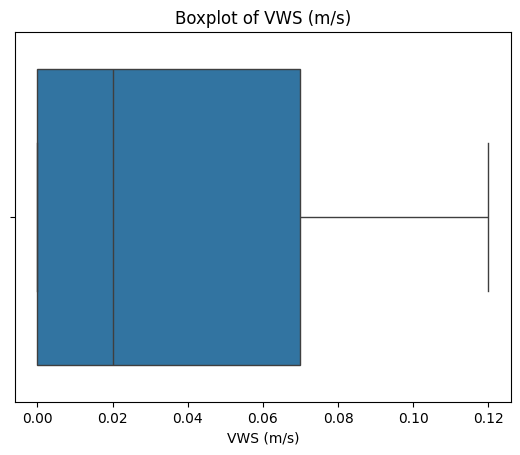

In [14]:
sns.boxplot(x=df['VWS (m/s)'])
plt.title('Boxplot of VWS (m/s)')
plt.show()

The boxplot shows that VWS values are mostly concentrated below 0.06 m/s with low variability. After cleaning and capping, extreme outliers have been effectively removed, resulting in a right-skewed but compact distribution.

In [15]:
def cap_outliers(df, cols, lower=0.01, upper=0.99):
    for col in cols:
        q_low = df[col].quantile(lower)
        q_high = df[col].quantile(upper)
        df[col] = np.clip(df[col], q_low, q_high)
    return df

**Log Transformation on PM2.5**

In [16]:
df['PM2.5 (ug/m3)'] = np.log1p(df['PM2.5 (ug/m3)'])

**Time Series Plot of Air Temperature and Key Pollutants**

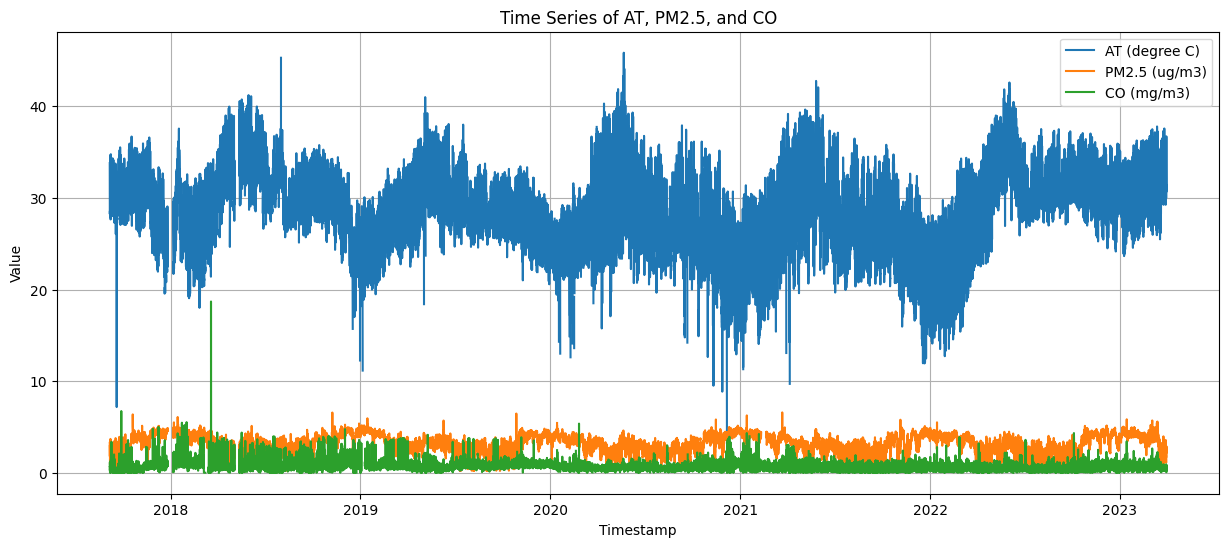

In [17]:
# Time series suhu dan polutan
plt.figure(figsize=(15, 6))
for col in ['AT (degree C)', 'PM2.5 (ug/m3)', 'CO (mg/m3)']:
    plt.plot(df.index, df[col], label=col)

plt.legend()
plt.title("Time Series of AT, PM2.5, and CO")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.grid(True)
plt.show()

The time series plot shows the variation of air temperature (AT), PM2.5, and CO levels from 2017 to 2023. The air temperature demonstrates a clear seasonal pattern with periodic peaks and troughs, likely reflecting annual climate cycles. In contrast, PM2.5 and CO values fluctuate at lower ranges with occasional spikes, indicating short-term pollution events.

**Correlation Analysis with Air Temperature (AT)**

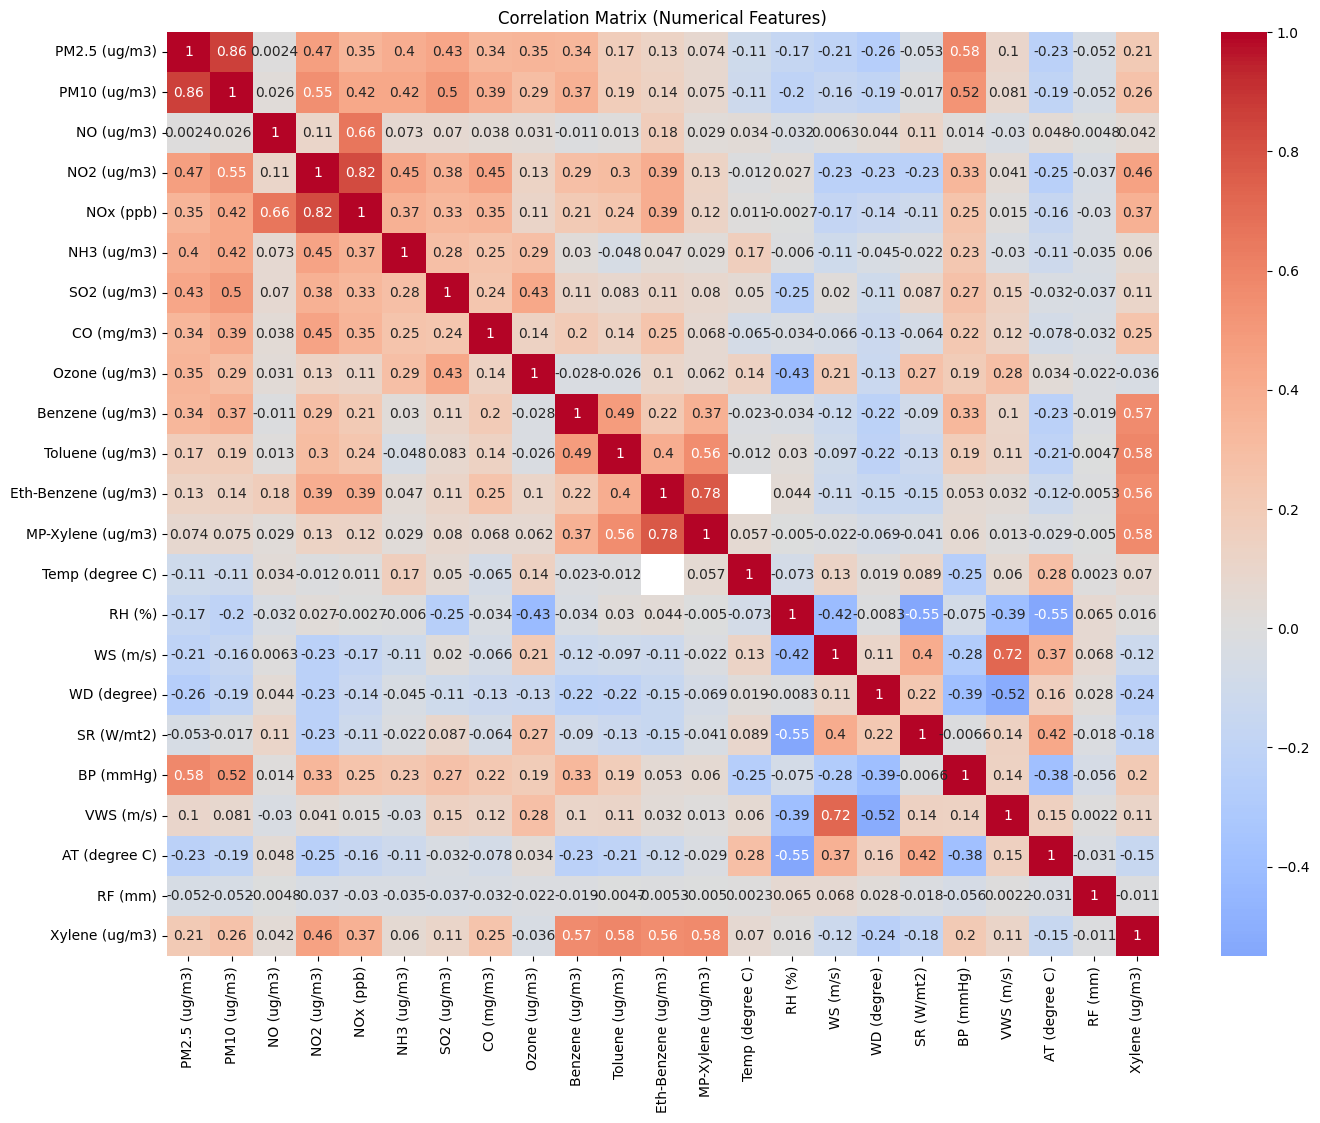

Top features correlated with AT:
 SR (W/mt2)           0.421172
WS (m/s)             0.369179
Temp (degree C)      0.283260
WD (degree)          0.159672
VWS (m/s)            0.149711
NO (ug/m3)           0.047684
Ozone (ug/m3)        0.034348
MP-Xylene (ug/m3)   -0.028933
RF (mm)             -0.031022
SO2 (ug/m3)         -0.031776
Name: AT (degree C), dtype: float64


In [18]:
# Korelasi antar semua fitur numerik
corr = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=True)
plt.title("Correlation Matrix (Numerical Features)")
plt.show()

# Top korelasi terhadap AT
target_corr = corr['AT (degree C)'].drop('AT (degree C)').sort_values(ascending=False)
print("Top features correlated with AT:\n", target_corr.head(10))

The top features most correlated with air temperature (AT) include solar radiation (SR) and wind speed (WS), both showing moderate positive correlations of 0.42 and 0.37 respectively, suggesting that higher sunlight and wind tend to coincide with higher temperatures. Temp (degree C) also correlates positively with AT, as expected, given its similarity in physical meaning. Other features like wind direction (WD) and vertical wind speed (VWS) show weaker but still positive correlations. Meanwhile, several pollutants such as SO2, RF, and MP-Xylene display slight negative correlations, indicating a potential inverse relationship with air temperature.

**Pairplot Analysis of Nitrogen Oxides (NO, NO₂, NOₓ)**

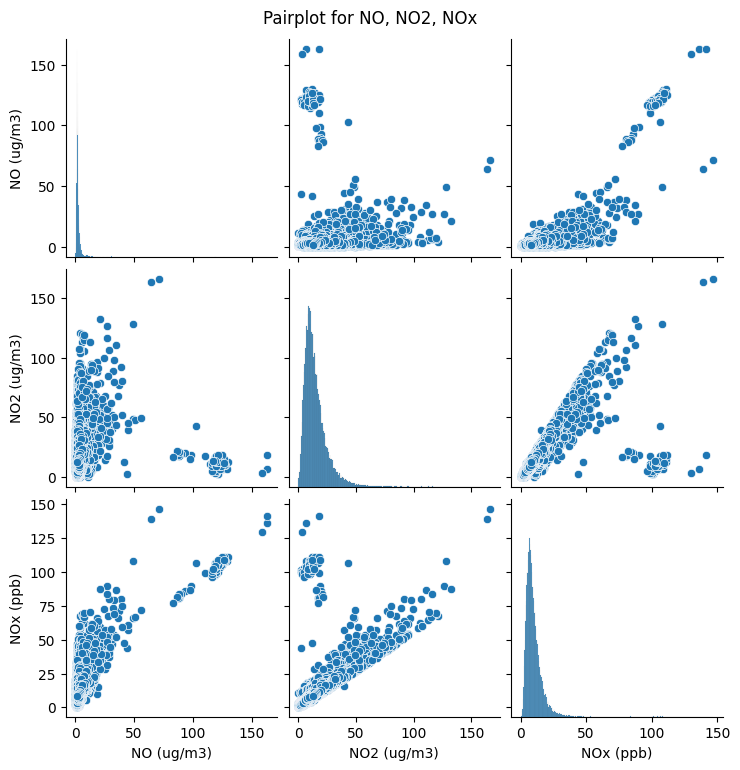

In [19]:
# Pairplot untuk NO, NO2, NOx
subset = df[['NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)']].dropna()
sns.pairplot(subset)
plt.suptitle("Pairplot for NO, NO2, NOx", y=1.02)
plt.show()

The pairplot of NO, NO₂, and NOₓ reveals strong positive linear relationships, particularly between NO₂ and NOₓ, as well as NO and NOₓ, reflecting their common origin from combustion processes. The tight clustering and aligned patterns indicate high collinearity, which suggests that these features may carry overlapping information in modeling tasks.

**ADF Test for Stationarity**

In [20]:
from statsmodels.tsa.stattools import adfuller

at_series = df['AT (degree C)'].dropna()
result = adfuller(at_series)

print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("→ AT is stationary (reject H0)")
else:
    print("→ AT is non-stationary (fail to reject H0)")

ADF Statistic: -6.483653292743221
p-value: 1.2766380940140788e-08
→ AT is stationary (reject H0)


The result of the Augmented Dickey-Fuller (ADF) test shows an ADF statistic of -6.48 with a very small p-value (~1.28e-08), well below the 0.05 threshold. This indicates that the air temperature (AT) series is stationary, allowing us to reject the null hypothesis (H0) of a unit root or non-stationary behavior.

## 🔍 **DATA PREPROCESSING**

**Handling Missing Values with Interpolation and Median Imputation**

In [21]:
df.interpolate(method='time', inplace=True)
df = df.fillna(df.median(numeric_only = True))
# df.dropna(inplace=True)
print("Total missing values after interpolation:", df.isna().sum().sum())

Total missing values after interpolation: 0


/tmp/ipython-input-21-2746115356.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='time', inplace=True)


**Stationarity Check Across All Numerical Features (ADF Test)**

In [22]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(df):
    print("ADF Stationarity Test per Feature:\n")
    for col in df.select_dtypes(include='number').columns:
        series = df[col].dropna()
        try:
            result = adfuller(series)
            pval = result[1]
            print(f"{col:<25} | ADF p-value: {pval:.4f} | {'✅ Stationary' if pval < 0.05 else '❌ Non-Stationary'}")
        except Exception as e:
            print(f"{col:<25} | ❌ ADF test error: {e}")

In [23]:
check_stationarity(df)

ADF Stationarity Test per Feature:

PM2.5 (ug/m3)             | ADF p-value: 0.0000 | ✅ Stationary
PM10 (ug/m3)              | ADF p-value: 0.0000 | ✅ Stationary
NO (ug/m3)                | ADF p-value: 0.0000 | ✅ Stationary
NO2 (ug/m3)               | ADF p-value: 0.0000 | ✅ Stationary
NOx (ppb)                 | ADF p-value: 0.0000 | ✅ Stationary
NH3 (ug/m3)               | ADF p-value: 0.0000 | ✅ Stationary
SO2 (ug/m3)               | ADF p-value: 0.0000 | ✅ Stationary
CO (mg/m3)                | ADF p-value: 0.0000 | ✅ Stationary
Ozone (ug/m3)             | ADF p-value: 0.0000 | ✅ Stationary
Benzene (ug/m3)           | ADF p-value: 0.0000 | ✅ Stationary
Toluene (ug/m3)           | ADF p-value: 0.0000 | ✅ Stationary
Eth-Benzene (ug/m3)       | ADF p-value: 0.0000 | ✅ Stationary
MP-Xylene (ug/m3)         | ADF p-value: 0.0000 | ✅ Stationary
Temp (degree C)           | ADF p-value: 0.0000 | ✅ Stationary
RH (%)                    | ADF p-value: 0.0000 | ✅ Stationary
WS (m/s)           

The Augmented Dickey-Fuller (ADF) test was performed on all numerical features to evaluate their stationarity. Remarkably, all variables returned p-values of 0.0000, indicating strong evidence against the null hypothesis of non-stationarity. This means every numerical feature in the dataset—including pollutants, meteorological factors, and the target variable AT (degree C)—can be considered stationary. As a result, no differencing or additional transformation is required before modeling, which simplifies the LSTM input preparation.

**Feature Selection via Granger Causality Test**

In [24]:
from statsmodels.tsa.stattools import grangercausalitytests

def granger_feature_selection(df, target='AT (degree C)', maxlag=24, threshold=0.05):
    selected_features = []
    for col in df.columns:
        if col == target:
            continue
        try:
            test_result = grangercausalitytests(df[[target, col]], maxlag=maxlag, verbose=False)
            p_values = [test_result[i+1][0]['ssr_chi2test'][1] for i in range(maxlag)]
            if any(p < threshold for p in p_values):
                print(f"✅ {col:<25} has Granger causality (p < {threshold})")
                selected_features.append(col)
            else:
                print(f"❌ {col:<25} no Granger causality")
        except Exception as e:
            print(f"⚠️  Skipped {col} due to error: {e}")
    return selected_features

In [25]:
selected_features = granger_feature_selection(df, target='AT (degree C)', maxlag=24)
print("\nSelected Features with Granger Causality:", selected_features)

⚠️  Skipped To Date due to error: could not convert string to float: '2017-09-05 15:00:00'


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ PM2.5 (ug/m3)             has Granger causality (p < 0.05)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ PM10 (ug/m3)              has Granger causality (p < 0.05)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ NO (ug/m3)                has Granger causality (p < 0.05)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ NO2 (ug/m3)               has Granger causality (p < 0.05)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ NOx (ppb)                 has Granger causality (p < 0.05)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ NH3 (ug/m3)               has Granger causality (p < 0.05)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ SO2 (ug/m3)               has Granger causality (p < 0.05)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ CO (mg/m3)                has Granger causality (p < 0.05)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ Ozone (ug/m3)             has Granger causality (p < 0.05)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ Benzene (ug/m3)           has Granger causality (p < 0.05)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ Toluene (ug/m3)           has Granger causality (p < 0.05)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ Eth-Benzene (ug/m3)       has Granger causality (p < 0.05)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ MP-Xylene (ug/m3)         has Granger causality (p < 0.05)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ Temp (degree C)           has Granger causality (p < 0.05)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ RH (%)                    has Granger causality (p < 0.05)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ WS (m/s)                  has Granger causality (p < 0.05)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ WD (degree)               has Granger causality (p < 0.05)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ SR (W/mt2)                has Granger causality (p < 0.05)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ BP (mmHg)                 has Granger causality (p < 0.05)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ VWS (m/s)                 has Granger causality (p < 0.05)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ RF (mm)                   has Granger causality (p < 0.05)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


✅ Xylene (ug/m3)            has Granger causality (p < 0.05)

Selected Features with Granger Causality: ['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)', 'Eth-Benzene (ug/m3)', 'MP-Xylene (ug/m3)', 'Temp (degree C)', 'RH (%)', 'WS (m/s)', 'WD (degree)', 'SR (W/mt2)', 'BP (mmHg)', 'VWS (m/s)', 'RF (mm)', 'Xylene (ug/m3)']


The Granger causality test results showed that nearly all features—including air pollutants (like PM2.5, NOx, CO), meteorological variables (such as RH, WS, SR), and chemical compounds (e.g., Benzene, Toluene)—exhibited significant predictive influence over the air temperature (AT (degree C)) time series with p-values below 0.05. This confirms their temporal relevance and justifies their inclusion as input features in the multivariate LSTM forecasting model, as they carry valuable lag-based information useful for predicting AT dynamics.

In [26]:
final_features = selected_features
df_lstm = df[final_features + ['AT (degree C)']]

**Feature Scaling with MinMaxScaler**

In [27]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_lstm)
df_scaled = pd.DataFrame(scaled, columns=df_lstm.columns, index=df_lstm.index)

**Sequence Generation for Time Series Modeling with LSTM**

In [28]:
def create_sequences(data, target_col_index, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i, target_col_index])
    return np.array(X), np.array(y)

window_size = 5
target_col_index = df_scaled.columns.get_loc('AT (degree C)')

X, y = create_sequences(df_scaled, target_col_index, window_size)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (48797, 5, 23)
y shape: (48797,)


The generated sequences consist of 48,797 samples, where each input sample (X) is a 5-step time window containing 23 features, and each target (y) corresponds to the value of AT (degree C) immediately following that window.

**Data Splitting**

In [29]:
total_samples = len(X)
train_end = int(total_samples * 0.8)
val_end = int(total_samples * 0.9)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (39037, 5, 23) (39037,)
Validation: (4880, 5, 23) (4880,)
Test: (4880, 5, 23) (4880,)


Each sample consists of a sequence of 5 time steps and 23 features, with the target being the temperature (AT (degree C)) at the current time step following each sequence.

## **🧪 Model 1 – BASELINE LSTM**

In [30]:
model_baseline = Sequential([
    LSTM(10, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1, activation='linear')  # Aktivasi linear untuk regresi
])

model_baseline.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model_baseline.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │         1,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,371 (5.36 KB)

 Trainable params: 1,371 (5.36 KB)

 Non-trainable params: 0 (0.00 B)

The model consists of a single LSTM layer with 10 units, followed by a dense output layer with a linear activation—appropriate for regression tasks like predicting temperature. You compiled the model with the Adam optimizer, using mean squared error (MSE) as the loss function and mean absolute error (MAE) as an evaluation metric.

In [31]:
history = model_baseline.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=256,
    verbose=1
)

Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0855 - mae: 0.2201 - val_loss: 0.0103 - val_mae: 0.0810
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0088 - mae: 0.0745 - val_loss: 0.0079 - val_mae: 0.0722
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0067 - mae: 0.0645 - val_loss: 0.0061 - val_mae: 0.0639
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0054 - mae: 0.0577 - val_loss: 0.0048 - val_mae: 0.0573
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0042 - mae: 0.0504 - val_loss: 0.0038 - val_mae: 0.0513
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0032 - mae: 0.0436 - val_loss: 0.0028 - val_mae: 0.0440
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0024 - mae: 0.0376 - val_loss: 0.0023 - val_mae: 0.0392
Epoch 8/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020 - mae: 0.0334 - val_loss: 0.0019 - val_mae: 0.0354
Epoch 9/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo

The model was trained on the training set for 20 epochs using a batch size of 256. It also used the validation set to monitor performance during training. The verbose=1 setting provided detailed output per epoch. This process helped the model learn temporal dependencies between past data points (in 5-step sequences) and the target temperature value.

In [32]:
loss, mae = model_baseline.evaluate(X_test, y_test)
print(f"\nTest MSE  : {loss:.4f}")
print(f"Test MAE  : {mae:.4f}")

y_pred = model_baseline.predict(X_test)

r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"R² Score : {r2:.4f}")
print(f"MAPE     : {mape:.4%}")

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3409e-04 - mae: 0.0187

Test MSE  : 0.0006
Test MAE  : 0.0191
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² Score : 0.8604
MAPE     : 3.0163%


With a Test MAE of 0.0191 and MAPE of 3.02%, the model predictions are quite close to the actual values on average. The R² Score of 0.8604 also indicates that around 86% of the variance in temperature can be explained by the features used in the model.

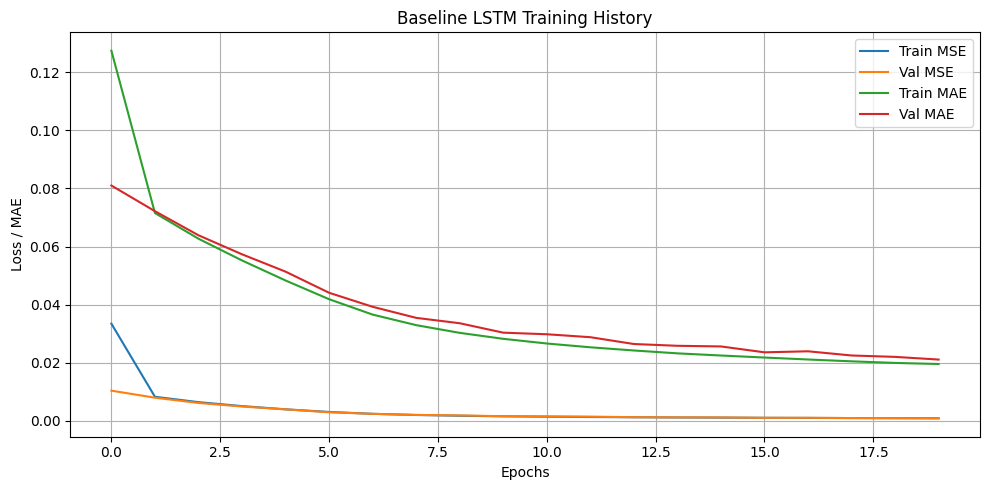

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss / MAE')
plt.title('Baseline LSTM Training History')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This training history plot shows that both the training and validation loss (MSE and MAE) steadily decreased over the epochs, which means the model is learning effectively without major signs of overfitting. The gap between training and validation lines is small, suggesting the model generalizes well on unseen data.

**Inverse Scaling for Target Variable (AT)**

In [34]:
target_scaler = MinMaxScaler()
target_scaler.fit(df[['AT (degree C)']])  # Fit ulang hanya untuk AT

y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = target_scaler.inverse_transform(y_pred)

**Visualization: Predicted vs Actual AT (°C)**

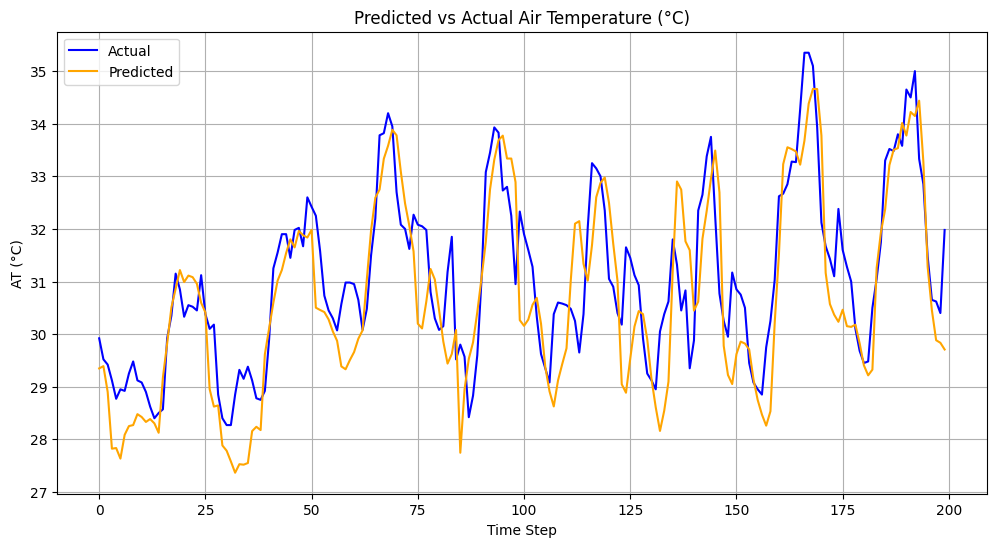

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:200], label='Actual', color='blue')
plt.plot(y_pred_inv[:200], label='Predicted', color='orange')
plt.title("Predicted vs Actual Air Temperature (°C)")
plt.xlabel("Time Step")
plt.ylabel("AT (°C)")
plt.legend()
plt.grid(True)
plt.show()

This plot shows a comparison between the predicted and actual air temperature (AT) values over the first 200 time steps from the test set. The blue line represents the actual AT values, while the orange line is what the LSTM model predicted.

From the graph, we can see that the model is able to follow the general pattern and trend of the temperature pretty well. Most of the time, the predictions are close to the actual values, especially during peaks and drops. However, there are still some slight delays and mismatches at certain points, which is normal for a baseline model without too much tuning.

Overall, the model has learned the temporal dynamics of air temperature reasonably well and gives a solid starting point for improvement. Better tuning or adding more LSTM layers might help reduce the small gaps we still see.

## **🔧 Model 2 – MODIFIED LSTM**

In [36]:
model_modified = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),  # LSTM pertama
    LSTM(32),  # LSTM kedua
    Dense(16, activation='relu'),  # Tambahan hidden Dense layer
    Dense(1, activation='linear')
])

model_modified.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model_modified.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 5, 64)          │        22,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,489 (138.63 KB)

 Trainable params: 35,489 (138.63 KB)

 Non-trainable params: 0 (0.00 B)

In this modified model, I added an extra LSTM layer and a hidden dense layer to improve learning capability compared to the baseline. Here’s what each part does:

- LSTM(64, return_sequences=True): This is the first LSTM layer that outputs sequences so it can feed into the next LSTM layer.
- LSTM(32): A second LSTM layer that condenses the temporal features.
- Dense(16, activation='relu'): An extra fully connected layer to learn more complex patterns.
- Dense(1, activation='linear'): The output layer for regression (predicting one continuous value).


In [37]:
history_modified = model_modified.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    verbose=1
)

Epoch 1/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0212 - mae: 0.0861 - val_loss: 0.0014 - val_mae: 0.0295
Epoch 2/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0013 - mae: 0.0261 - val_loss: 8.8921e-04 - val_mae: 0.0231
Epoch 3/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 9.0273e-04 - mae: 0.0215 - val_loss: 6.3132e-04 - val_mae: 0.0191
Epoch 4/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 6.9027e-04 - mae: 0.0187 - val_loss: 5.1796e-04 - val_mae: 0.0172
Epoch 5/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 5.9590e-04 - mae: 0.0172 - val_loss: 4.4776e-04 - val_mae: 0.0159
Epoch 6/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 5.1707e-04 - mae: 0.0159 - val_loss: 4.3214e-04 - val_mae: 0.0158
Epoch 7/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 4.8679e-04 - mae: 0.0152 - val_loss: 3.8745e-04 - val_mae: 0.0147
Epoch 8/20
610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 4.8404e-04 - mae: 0.0150 - val_loss: 3.8365e-04 - val_mae: 0.0146
Epoc

In [38]:
loss, mae = model_modified.evaluate(X_test, y_test)
print(f"\nTest MSE  : {loss:.4f}")
print(f"Test MAE  : {mae:.4f}")

y_pred = model_modified.predict(X_test)

r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"R² Score : {r2:.4f}")
print(f"MAPE     : {mape:.4%}")

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2606e-04 - mae: 0.0110

Test MSE  : 0.0002
Test MAE  : 0.0112
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
R² Score : 0.9447
MAPE     : 1.7543%


**The modified LSTM model shows a clear improvement over the baseline. With a lower Test MAE (0.0112 vs. 0.0191), lower MSE (0.0002 vs. 0.0006), and higher R² score (0.9447 vs. 0.8604), it predicts air temperature more accurately. The MAPE is also reduced to 1.75%, meaning the model's predictions are very close to the actual values.**

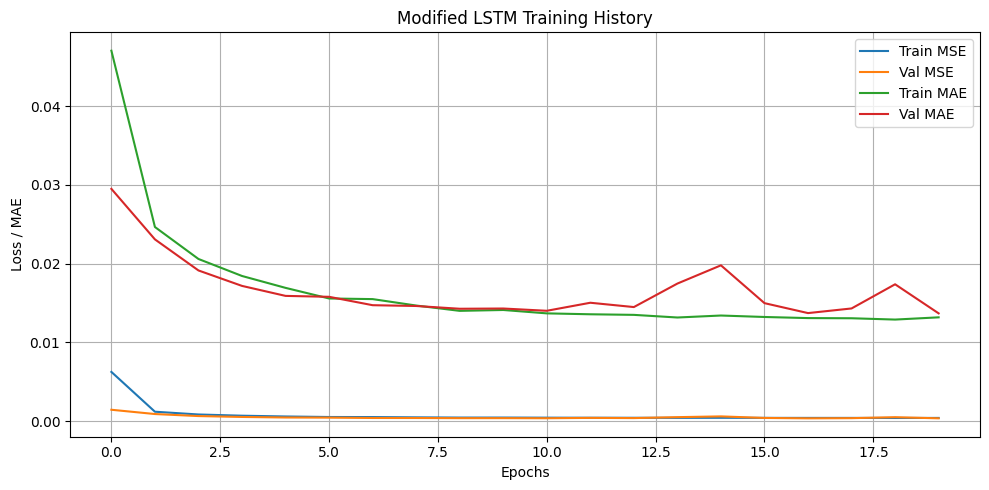

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(history_modified.history['loss'], label='Train MSE')
plt.plot(history_modified.history['val_loss'], label='Val MSE')
plt.plot(history_modified.history['mae'], label='Train MAE')
plt.plot(history_modified.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss / MAE')
plt.title('Modified LSTM Training History')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This training history plot for the modified LSTM shows steady improvements in both loss (MSE) and MAE during training. The training and validation MSE curves are very low and stable, which suggests that the model is learning well and not overfitting. Although the validation MAE curve shows some small fluctuations after epoch 10, it still trends downward overall and stays close to the training MAE. This means the model generalizes well to unseen data while capturing complex patterns effectively.

**Inverse Scaling for Target Variable (AT)**

In [40]:
target_scaler = MinMaxScaler()
target_scaler.fit(df[['AT (degree C)']])

y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = target_scaler.inverse_transform(y_pred)

**Visualization: Predicted vs Actual AT (°C)**

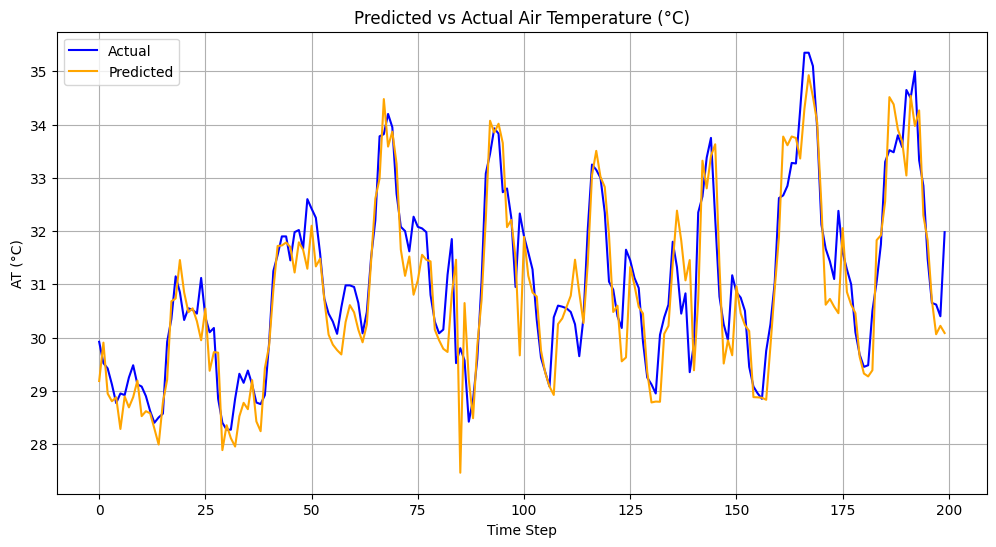

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:200], label='Actual', color='blue')
plt.plot(y_pred_inv[:200], label='Predicted', color='orange')
plt.title("Predicted vs Actual Air Temperature (°C)")
plt.xlabel("Time Step")
plt.ylabel("AT (°C)")
plt.legend()
plt.grid(True)
plt.show()

This plot compares the predicted air temperature (orange line) from the modified LSTM model with the actual temperature (blue line) for 200 time steps. We can see that the predicted values closely follow the actual trend, with only small deviations at certain points. This shows that the model is performing quite well in capturing the patterns of temperature changes over time, especially considering how complex and dynamic real-world weather data can be.

## **MODEL EVALUATION**

In [42]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

y_pred_baseline = model_baseline.predict(X_test)
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
mape_baseline = mean_absolute_percentage_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

y_pred_modified = model_modified.predict(X_test)
mse_modified = mean_squared_error(y_test, y_pred_modified)
mae_modified = mean_absolute_error(y_test, y_pred_modified)
mape_modified = mean_absolute_percentage_error(y_test, y_pred_modified)
r2_modified = r2_score(y_test, y_pred_modified)

eval_df = pd.DataFrame({
    "Model": ["Baseline", "Modified"],
    "MAE": [mae_baseline, mae_modified],
    "MSE": [mse_baseline, mse_modified],
    "MAPE (%)": [mape_baseline * 100, mape_modified * 100],
    "R² Score": [r2_baseline, r2_modified]
})

print("\n📊 Evaluation Table:")
display(eval_df.round(4))

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

📊 Evaluation Table:


,Model,MAE,MSE,MAPE (%),R² Score
0,Baseline,0.0191,0.0006,3.0163,0.8604
1,Modified,0.0112,0.0002,1.7543,0.9447


The evaluation results show that the baseline model performs reasonably well, with a Mean Absolute Error (MAE) of 0.0191, Mean Squared Error (MSE) of 0.0006, Mean Absolute Percentage Error (MAPE) of 3.02%, and an R² score of 0.86. This indicates the model captures the data patterns effectively, explaining about 86% of the variance in the observed data.

The modified model, however, demonstrates a significant improvement across all metrics. It achieves a lower MAE of 0.0112, MSE of 0.0002, MAPE of 1.75%, and a higher R² score of 0.94. The reductions in MAE and MSE indicate that predictions are closer to the actual values, while the decreased MAPE reflects a smaller relative prediction error. The higher R² score suggests that the modified model explains approximately 94% of the variability in the data, offering more accurate and consistent predictions.

In summary, the modifications made to the LSTM model greatly enhanced its predictive capability for air quality conditions, making the modified model the preferable choice for applications requiring high accuracy.

## **BONUS QUESTION**

**Apakah problem ini mungkin menggunakan time series multivariate, bagaimana mengetahui apakah problem tersebut dapat menjadi multivariate, jelaskan jawaban anda untuk problem ini!**

Yes, this problem is very suitable to be solved using multivariate time series methods because we have more than one time-dependent variable that may influence each other.

A time series problem becomes multivariate when we are not only using the target variable over time, but also including other related variables that also change over time. In this case, we are trying to predict air temperature (AT (degree C)), and we found that several other features like PM2.5, NO, CO, SR, and WS show strong correlation and even Granger causality with the temperature. That means these variables can help us better understand and predict the temperature trend. Since they are all recorded in the same time format and may affect the outcome, this makes the problem a multivariate time series prediction task.